In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = True

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
IS_INTERACTIVE = True
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 5
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

In [ ]:
import pandas as pd
import numpy as np
import json
import os
main_path = 'drive/MyDrive/AIS/'
wlas_df = pd.read_json(main_path+'WLASL_v0.3.json')
wlas_df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [ ]:
wlas_df.shape

(2000, 2)

In [ ]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance

    input: instance json list
    output: list of videos_ids

    """
    videos_list = []
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list

In [ ]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance

    input: instance json list
    output: list of videos_ids

    """
    videos_ids = []
    videos_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
    return videos_ids, videos_urls

In [ ]:
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)

In [ ]:
get_videos_ids(instance_json[0]['instances'])[0]

'69241'

In [ ]:
len(get_videos_ids(instance_json[0]['instances']))

6

In [ ]:
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)

In [ ]:
features_df = pd.DataFrame(columns=['gloss', 'video_id', 'url'])
for row in wlas_df.iterrows():
#     print(row[1][1])
    ids, urls = get_json_features(row[1][1])
    word = [row[1][0]] * len(ids)
    df = pd.DataFrame(list(zip(word, ids, urls)), columns = features_df.columns)
    #features_df = features_df.append(df, ignore_index=True)
    features_df = pd.concat([features_df, df], ignore_index=True)

<ipython-input-10-ab9b79f386ff>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ids, urls = get_json_features(row[1][1])
<ipython-input-10-ab9b79f386ff>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = [row[1][0]] * len(ids)


Task Dataframe

In [ ]:
features_df.index.name = 'index'
features_df

,gloss,video_id,url
index,,,
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4
1,book,07069,https://signstock.blob.core.windows.net/signsc...
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...
3,book,07070,https://media.asldeafined.com/vocabulary/14666...
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4
...,...,...,...
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...


In [ ]:
features_df.to_csv('features_df.csv', index=False)

In [ ]:
wlas_df.head()

,gloss,instances,videos_ids
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...","[69241, 07069, 07068, 07070, 07099, 07074]"
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...","[69302, 65539, 17710, 17733, 65540, 17734, 177..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[12328, 12312, 12311, 12338, 12313, 12314, 123..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[05728, 05749, 05750, 05729, 05730, 65167, 057..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[09848, 09869, 09849, 09850, 09851, 65328, 09854]"


3. Dataset Classes analysis

In [ ]:
wlas_df['samples_num'] = wlas_df['videos_ids'].apply(len)

In [ ]:
wlas_df.head()

,gloss,instances,videos_ids,samples_num
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...","[69241, 07069, 07068, 07070, 07099, 07074]",6
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...","[69302, 65539, 17710, 17733, 65540, 17734, 177...",15
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[12328, 12312, 12311, 12338, 12313, 12314, 123...",14
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[05728, 05749, 05750, 05729, 05730, 65167, 057...",16
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[09848, 09869, 09849, 09850, 09851, 65328, 09854]",7


In [ ]:
print("minimum number of samples for a word:", wlas_df['samples_num'].min())
print("maximum number of samples for a word:", wlas_df['samples_num'].max())

minimum number of samples for a word: 2
maximum number of samples for a word: 16


In [ ]:
words_sample_counts = wlas_df[['gloss', 'samples_num']].groupby('samples_num').agg({"gloss":['count', ', '.join]})

In [ ]:
words_sample_counts

gloss                                                   
            count                                               join
samples_num                                                         
2              14  gloves, careless, wash face, curtain, grey, la...
3              76  garage, parents, boots, excuse, furniture, rep...
4             335  hello, newspaper, asl, that, will, cards, hate...
5             511  clothes, table, movie, clock, pencil, behind, ...
6             402  book, birthday, need, have, knife, read, name,...
7             307  chair, dance, eat, forget, but, jacket, paint,...
8             151  all, blue, hearing, wrong, color, enjoy, time,...
9             100  fine, finish, now, can, hat, kiss, cow, meet, ...
10             48  year, black, hot, like, many, orange, fish, gr...
11             26  deaf, no, walk, mother, woman, dog, family, ap...
12             13  yes, what, later, man, shirt, change, corn, da...
13              8  candy, thanksgiving, bed, bowling, tall, accid...
14              4                        computer, who, cousin, help
15              2                                          drink, go
16              3                                 before, thin, cool

In [ ]:
# the words that have two samples
words_sample_counts.loc[2].values[1]

'gloves, careless, wash face, curtain, grey, lamp, look at, meaning, post, propaganda, ski, smoking, stepfather, tv'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

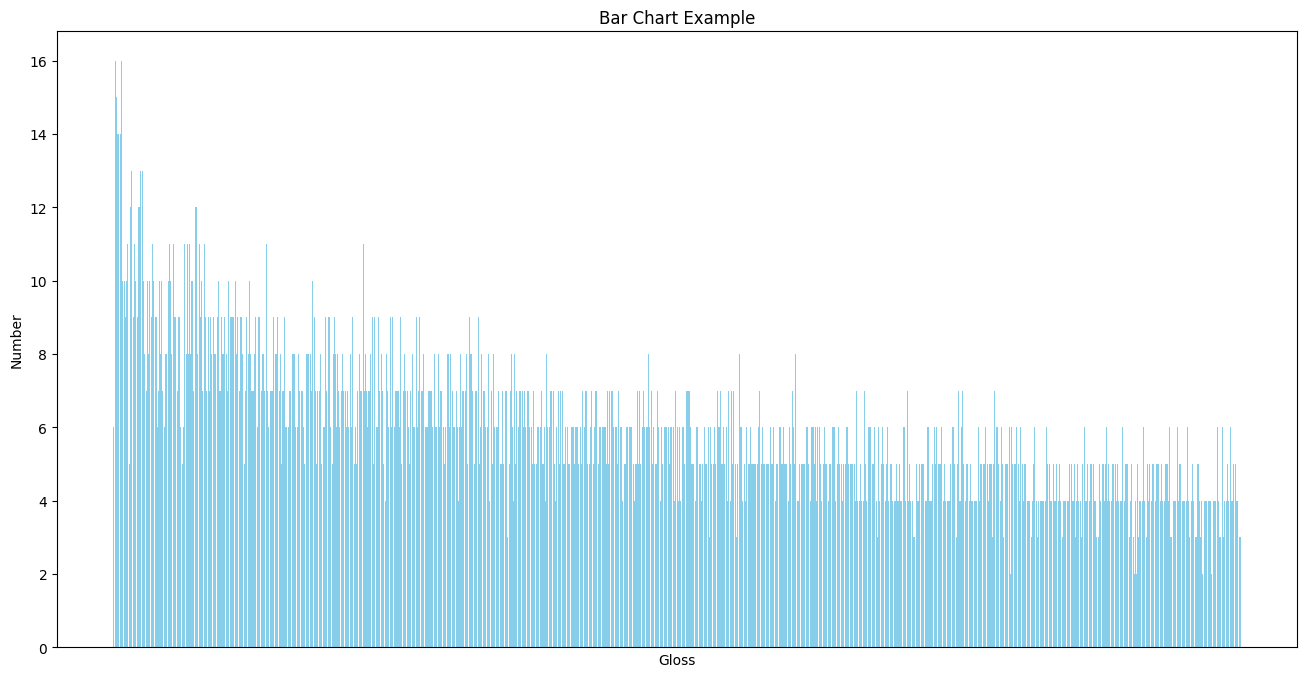

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.bar(wlas_df['gloss'], wlas_df['samples_num'], color='skyblue')
plt.title('Bar Chart Example')
plt.xlabel('Gloss')
plt.ylabel('Number')
plt.xticks([])
plt.show()

Testing videotransforms from github
Data agumentation

In [ ]:
import numpy as np
import numbers
import random

class RandomCrop(object):
    """Crop the given video sequences (t x h x w) at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    @staticmethod
    def get_params(img, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        t, h, w, c = img.shape
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th) if h!=th else 0
        j = random.randint(0, w - tw) if w!=tw else 0
        return i, j, th, tw

    def __call__(self, imgs):

        i, j, h, w = self.get_params(imgs, self.size)

        imgs = imgs[:, i:i+h, j:j+w, :]
        return imgs

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)

class CenterCrop(object):
    """Crops the given seq Images at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, imgs):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        t, h, w, c = imgs.shape
        th, tw = self.size
        i = int(np.round((h - th) / 2.))
        j = int(np.round((w - tw) / 2.))

        return imgs[:, i:i+th, j:j+tw, :]


    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)


class RandomHorizontalFlip(object):
    """Horizontally flip the given seq Images randomly with a given probability.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, imgs):
        """
        Args:
            img (seq Images): seq Images to be flipped.
        Returns:
            seq Images: Randomly flipped seq images.
        """
        if random.random() < self.p:
            # t x h x w
            return np.flip(imgs, axis=2).copy()
        return imgs

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

Extracting frames from videos

In [ ]:
!pip install opencv-python

In [ ]:
features_df.tail()

,gloss,video_id,url
index,,,
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...
11978,whistle,63188,https://www.signingsavvy.com/signs/mp4/9/9961.mp4
11979,whistle,63190,http://www.aslsearch.com/signs/videos/whistle.mp4


In [ ]:
import cv2
import os
from tqdm import tqdm

SEED = 42
N = int(1e3) if (True or not False) else int(10e3)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

video_folder = main_path + 'videos/'
video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.mp4')]

train = pd.DataFrame({'file_path': video_files})

for idx, file_path in enumerate(tqdm(train['file_path'].sample(N, random_state=SEED))):

    cap = cv2.VideoCapture(file_path)

    if not cap.isOpened():
        print(f"can not open file: {file_path}")
        continue

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_numbers = []

    for frame_idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame_numbers.append(frame_idx)

    cap.release()

    unique_frames = len(set(frame_numbers))
    missing_frames = (frame_numbers[-1] - frame_numbers[0]) - unique_frames + 1 if unique_frames > 0 else 0
    max_frame = max(frame_numbers) if unique_frames > 0 else 0

    N_UNIQUE_FRAMES[idx] = unique_frames
    N_MISSING_FRAMES[idx] = missing_frames
    MAX_FRAME[idx] = max_frame



100%|██████████| 1000/1000 [10:19<00:00,  1.61it/s]


,N_UNIQUE_FRAMES
count,1000.000000
mean,69.091000
std,26.927826
min,21.000000
1%,26.000000
5%,30.000000
25%,46.000000
50%,70.000000
75%,87.000000
95%,114.050000


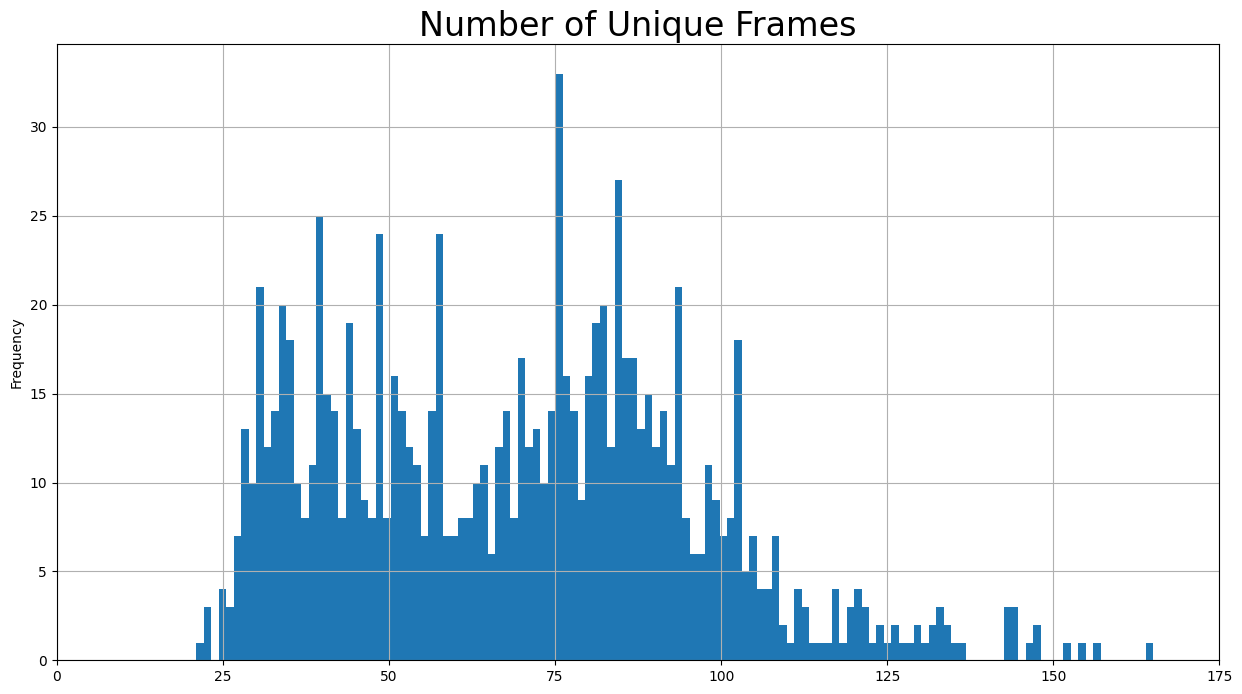

In [ ]:
import math
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,N_MISSING_FRAMES
count,1000.0
mean,0.0
std,0.0
min,0.0
1%,0.0
5%,0.0
25%,0.0
50%,0.0
75%,0.0
95%,0.0


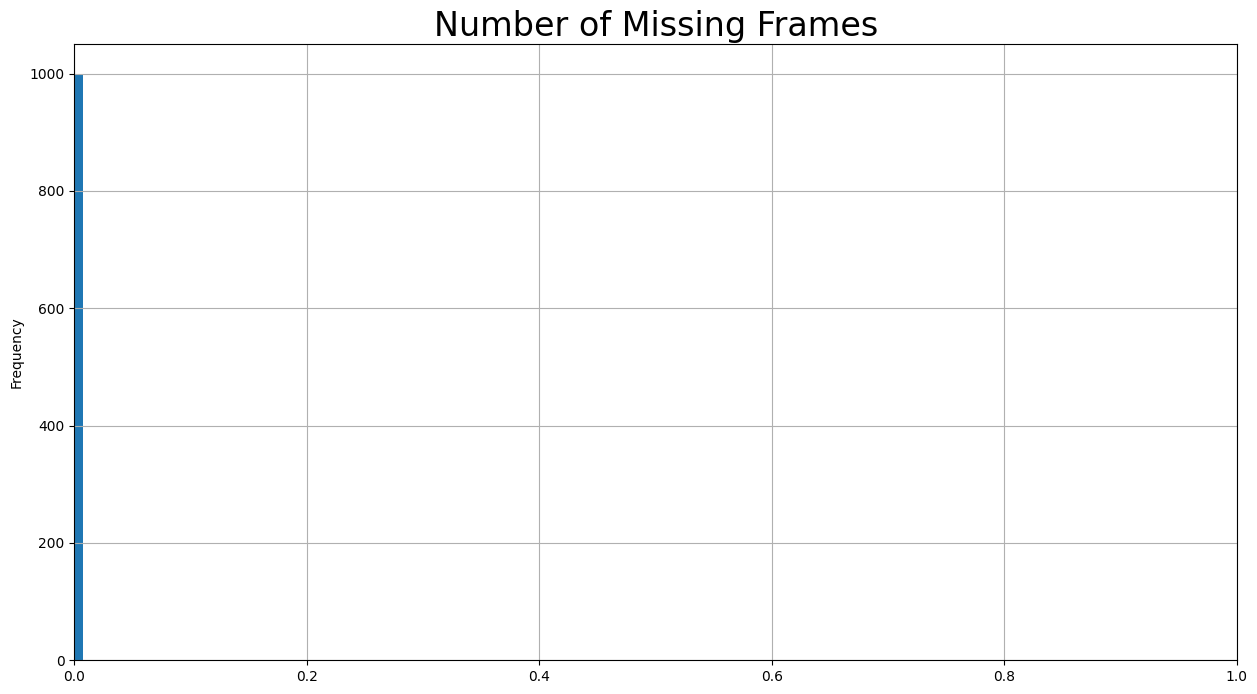

In [ ]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,MAX_FRAME
count,1000.000000
mean,68.091000
std,26.927826
min,20.000000
1%,25.000000
5%,29.000000
25%,45.000000
50%,69.000000
75%,86.000000
95%,113.050000


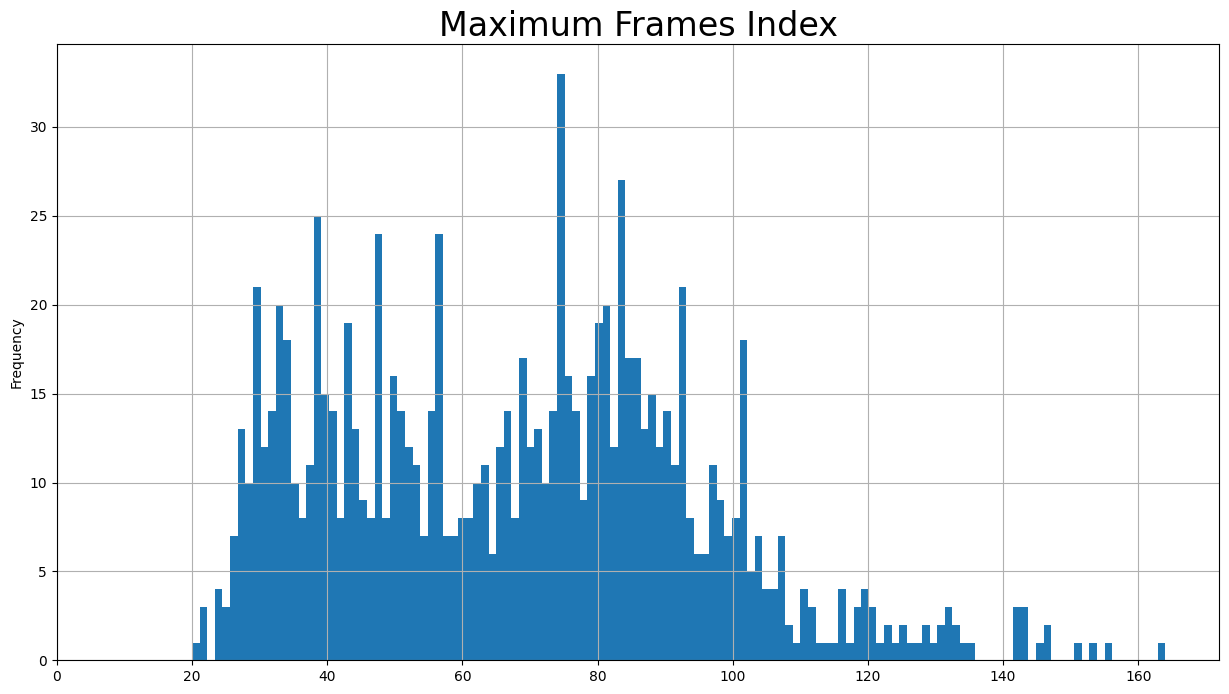

In [ ]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

Landmark Indices

In [ ]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [ ]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


Process Data Tensorflow

In [ ]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [ ]:
import tensorflow as tf
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
"""
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])

    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]

        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum

        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )

        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)

        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)

        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]

        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )

        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)

            return data, non_empty_frames_idxs

preprocess_layer = PreprocessLayer()

Interpolate NaN Values

In [ ]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544

"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)

    return data

Create Dataset

In [ ]:
dataset = pd.concat([features_df,train], axis=1)

In [ ]:
dataset.head()

,gloss,video_id,url,file_path
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4,drive/MyDrive/AIS/videos/65305.mp4
1,book,07069,https://signstock.blob.core.windows.net/signsc...,drive/MyDrive/AIS/videos/65323.mp4
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,drive/MyDrive/AIS/videos/65433.mp4
3,book,07070,https://media.asldeafined.com/vocabulary/14666...,drive/MyDrive/AIS/videos/65401.mp4
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,drive/MyDrive/AIS/videos/65301.mp4


In [ ]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
N_SAMPLES = len(train)
# Get the full dataset
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, gloss) in enumerate(tqdm(dataset[['file_path', 'gloss']].values)):
        # Log message every 5000 samples
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = gloss
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)
    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)
    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')

In [ ]:
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = '.'
else:
    ROOT_DIR = 'dataset_path' #change path here

# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AIS/X_train.npy'

In [ ]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

Number Of Frames

In [ ]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1)
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

Percentage of Frames Filled

In [ ]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

Feature Statistics - Lips

In [ ]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

In [ ]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

Feature Statistics - Hands

In [ ]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

In [ ]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T

    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

Feature Statistics - Pose

In [ ]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

In [ ]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()